In [1]:
#loading the necessary python libraries
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [2]:
floats_data = pd.read_csv('../data-sources/forecasting-floats/atlantic-data.csv')
floats_data.head()

,significantWaveHeight [m],peakPeriod [s],meanPeriod [s],peakDirection [degrees],peakDirectionalSpread [degrees],meanDirection [degrees],meanDirectionalSpread [degrees],timestamp [utc],latitude [decimal degrees],longitude [decimal degrees],epoch [s],spotId
0,1.576,6.827,5.231,268.062,26.141,245.366,52.564,2021-05-30 00:16:49+00:00,34.95782,290.06765,1622333809,0
1,1.544,6.827,5.159,264.063,30.325,242.607,53.059,2021-05-30 01:16:49+00:00,34.96202,290.06473,1622337409,0
2,1.590,7.314,5.288,267.427,31.451,243.648,51.565,2021-05-30 02:16:49+00:00,34.96605,290.06040,1622341009,0
3,1.617,7.314,5.229,263.254,34.004,236.917,53.388,2021-05-30 03:16:49+00:00,34.97025,290.05493,1622344609,0
4,1.547,7.314,5.278,265.768,31.605,239.341,52.841,2021-05-30 04:16:49+00:00,34.97540,290.04875,1622348209,0


In [3]:
floats_data.columns = [column.split(' ')[0] for column in floats_data.columns]
floats_data.drop(columns=['timestamp', 'epoch'], inplace=True)
floats_data = floats_data[['spotId'] + [column for column in floats_data.columns if column != 'spotId']]

In [4]:
floats_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51888 entries, 0 to 51887
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   spotId                 51888 non-null  int64  
 1   significantWaveHeight  51888 non-null  float64
 2   peakPeriod             51888 non-null  float64
 3   meanPeriod             51888 non-null  float64
 4   peakDirection          51888 non-null  float64
 5   peakDirectionalSpread  51888 non-null  float64
 6   meanDirection          51888 non-null  float64
 7   meanDirectionalSpread  51888 non-null  float64
 8   latitude               51888 non-null  float64
 9   longitude              51888 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 4.0 MB


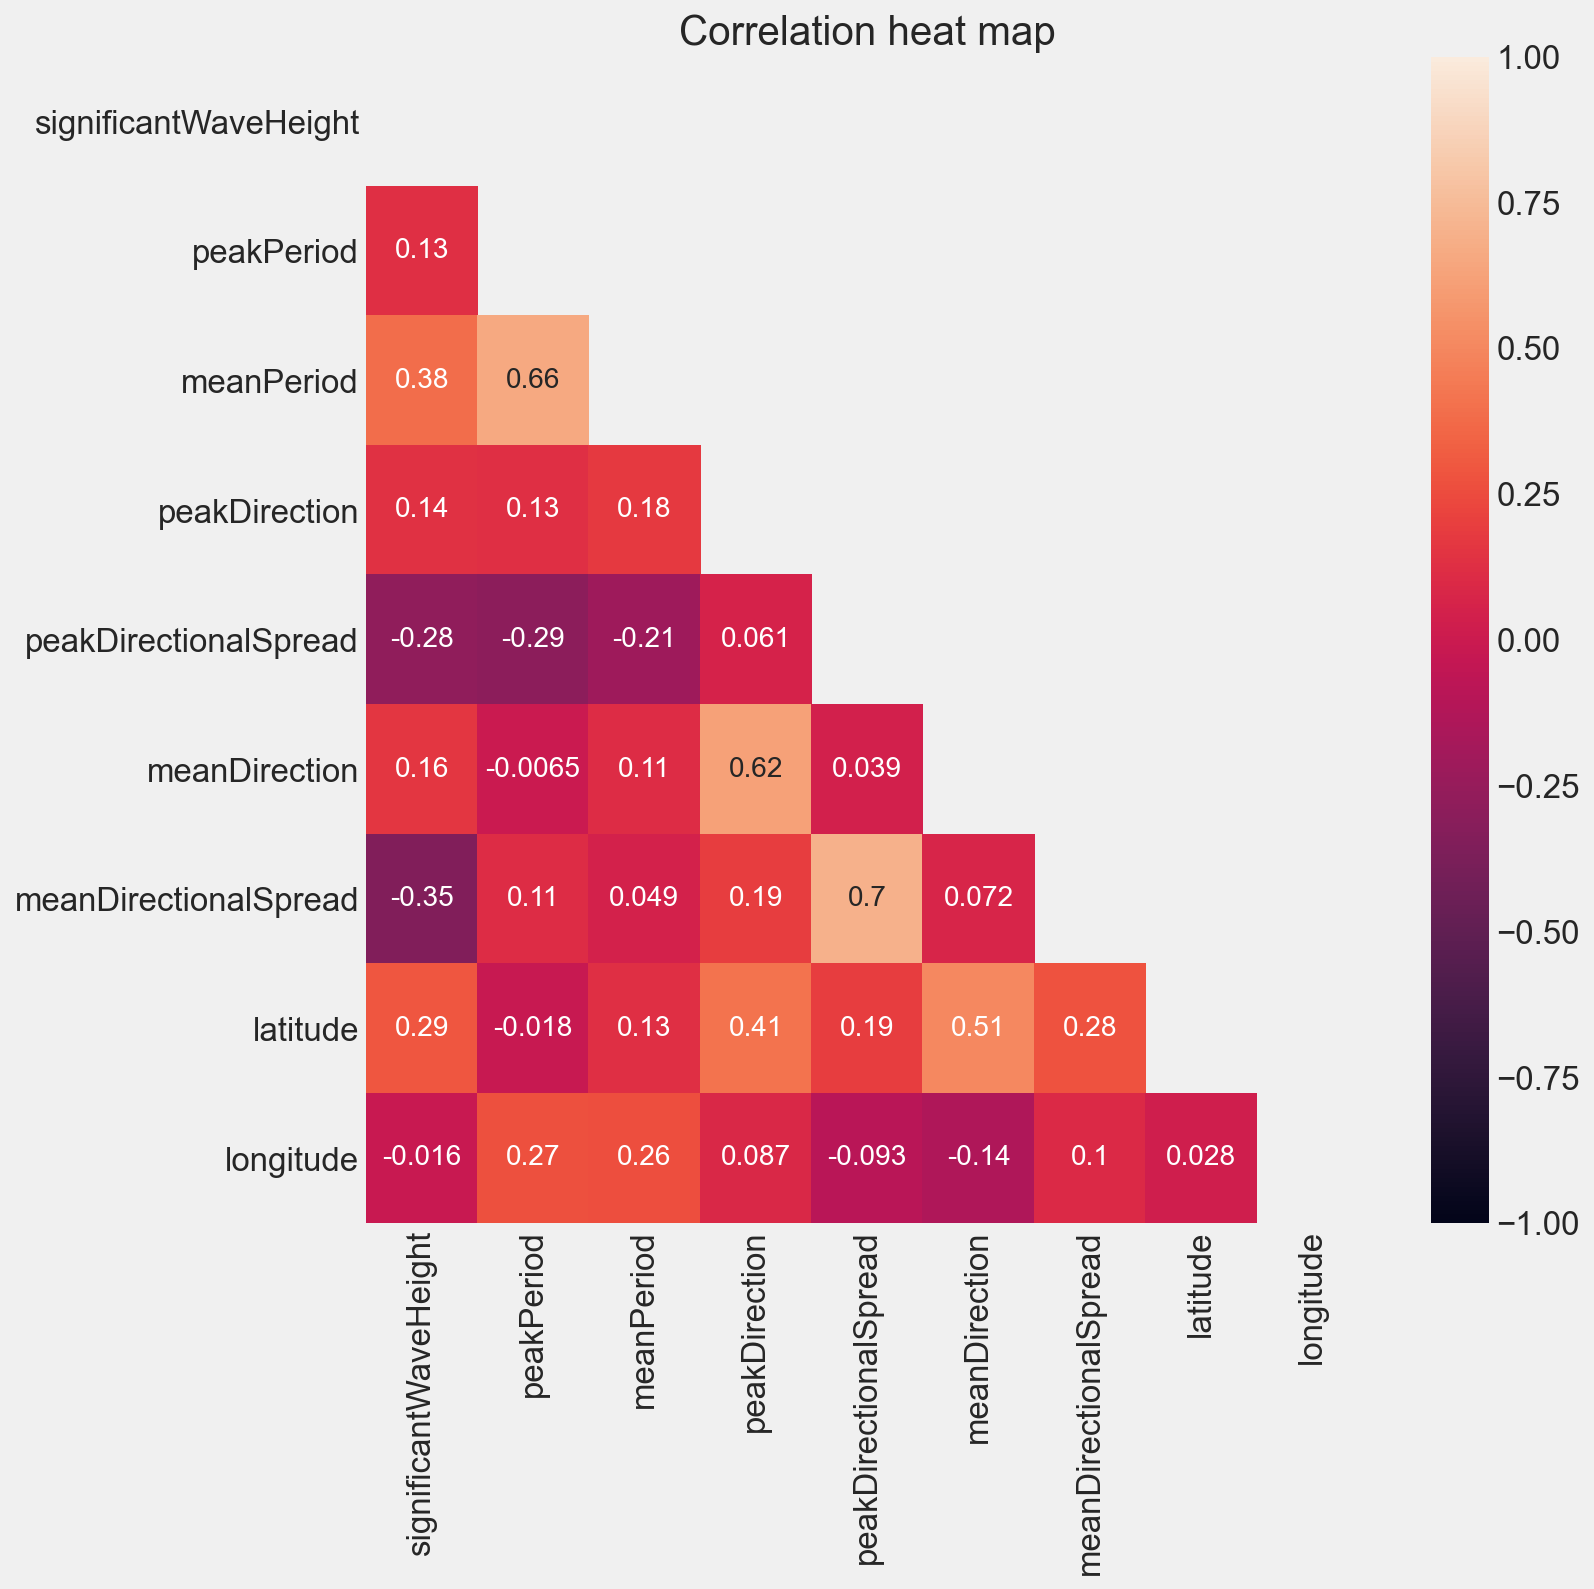

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
mask = np.zeros_like(floats_data[floats_data.columns[1:]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(floats_data[floats_data.columns[1:]].corr(), mask=mask, annot=True, vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation heat map')
plt.show()

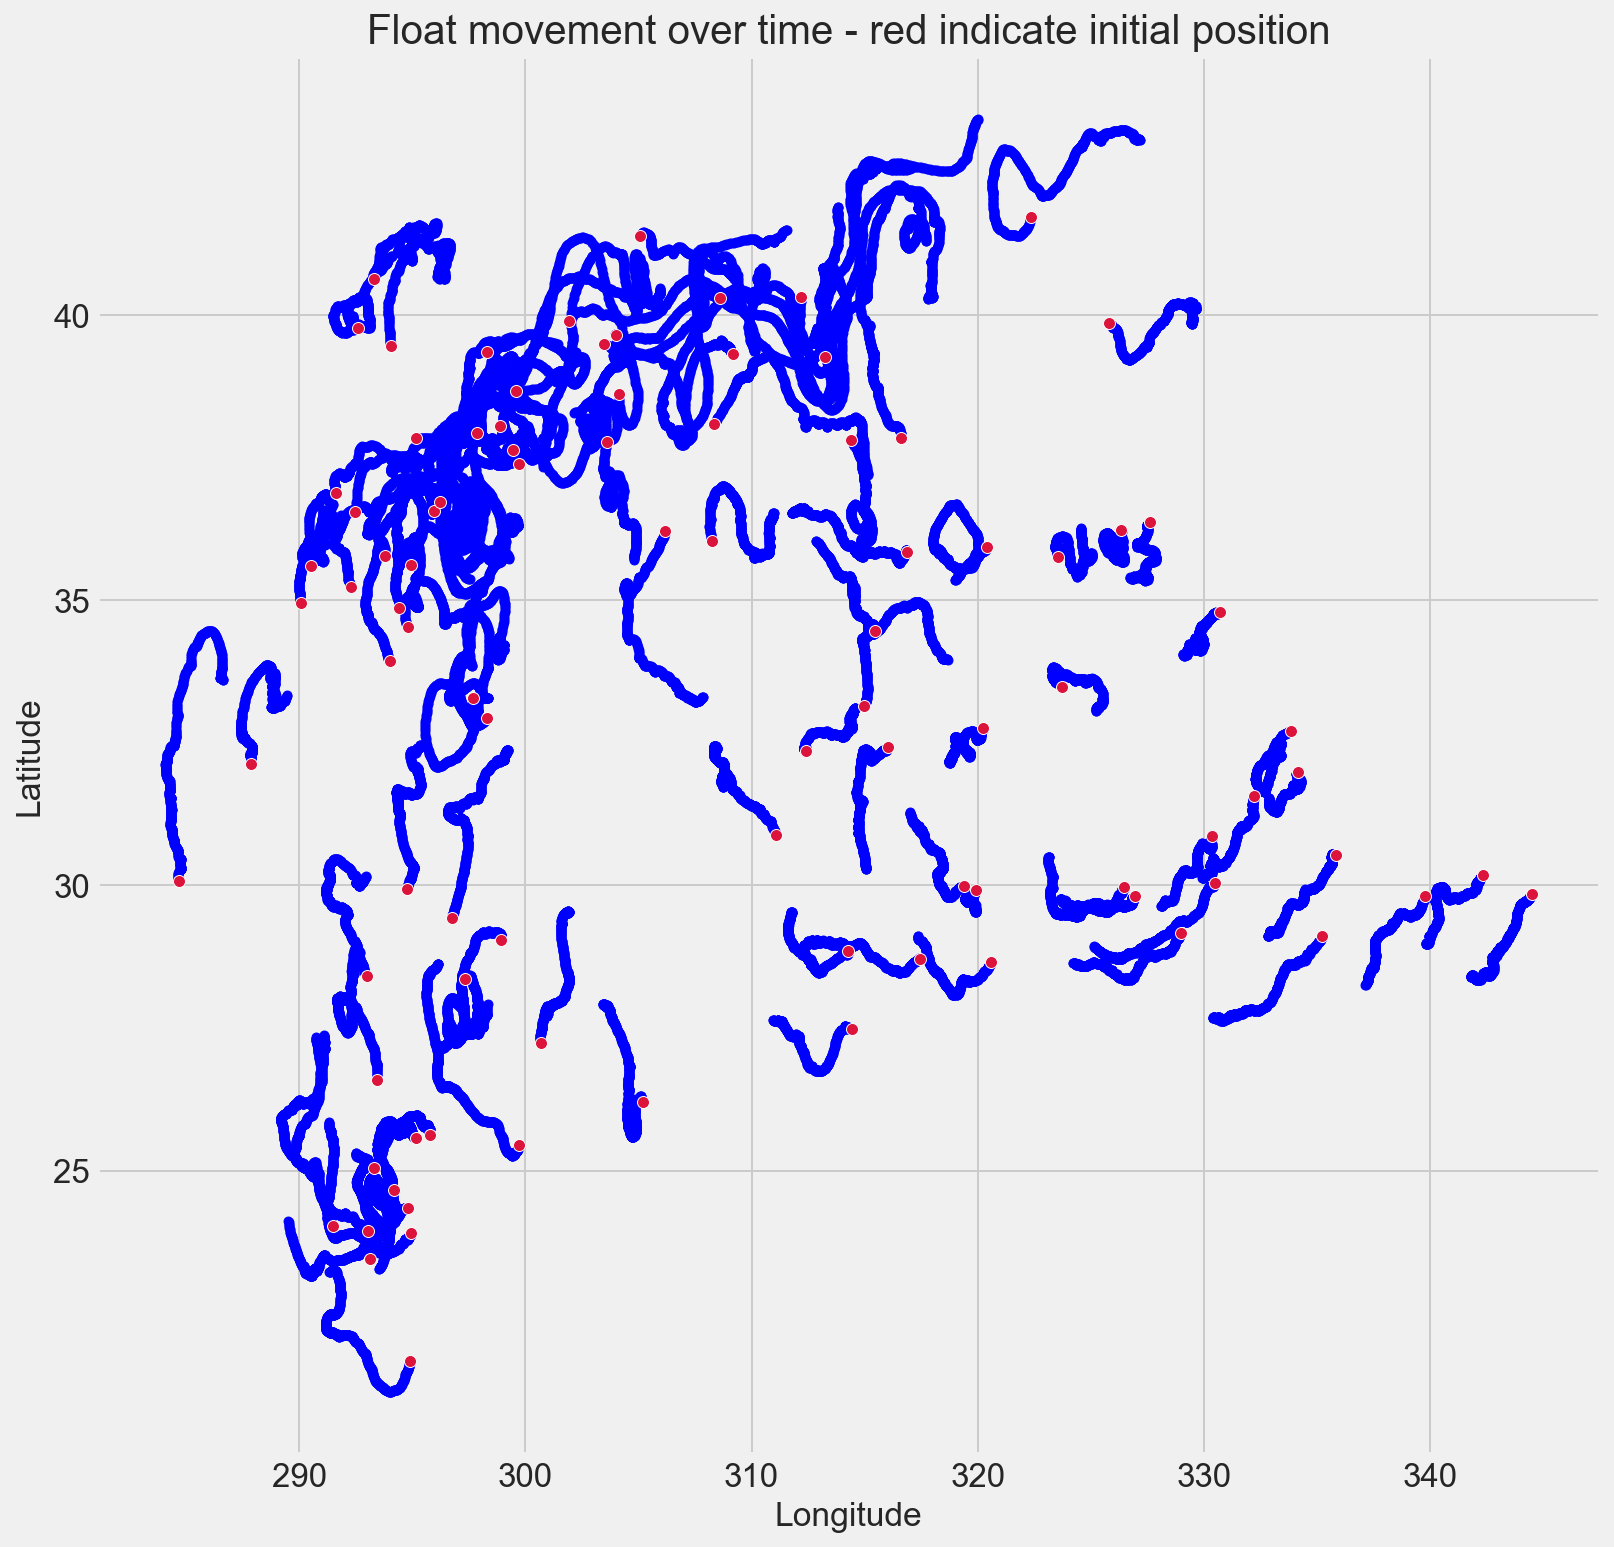

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))
floats_data.plot(kind='scatter', x='longitude', y='latitude', c=['blue'], ax=ax)
for floater in floats_data['spotId'].unique():
    sns.scatterplot(data=floats_data[floats_data['spotId'] == floater][:1],
                x='longitude', y='latitude', c=['crimson'], ax=ax)
ax.set_title('Float movement over time - red indicate initial position')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()